# Homework 6
**name:** Mina Stojanovic  
**github id:** minastoj  
**USC student id:** 4968308304  

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

### Question 1
#### Tree-Based Methods  
(b) i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.  

Missing values are usually dealt with using the following kinds of techniques: imputation and deletion. Since there is a large amount of missing value, deletion isn't a viable option. In terms of imputation, there are:  
1. Mean/Median imputation: Replacing missing values with the mean or median value of the feature.  
2. KNN imputation: Using the average value of the nearest neighbors to fill in missing data.  
3. Regression imputation: Using a regression model to predict missing values based on other features.  
4. Multiple imputation: Creating multiple complete datasets by filling in missing values with different plausible estimates, then analyzing each dataset separately and combining the results.  

I will apply mean imputation to the dataset.

In [2]:
training_data = pd.read_csv('../data/aps_failure_training_set.csv', delimiter=',', skiprows=20)
testing_data = pd.read_csv('../data/aps_failure_test_set.csv', delimiter=',', skiprows=20)

# swapping "na" with NaN
training_data.replace("na", np.nan, inplace=True)
testing_data.replace("na", np.nan, inplace=True)

# swapping neg with 0 and pos with 1
training_data['class'].replace("neg", 0, inplace=True)
training_data['class'].replace("pos", 1, inplace=True)
testing_data['class'].replace("neg", 0, inplace=True)
testing_data['class'].replace("pos", 1, inplace=True)

# REFERENCE: Site #1
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# mean impute training & testing data
training_data = pd.DataFrame(mean_imputer.fit_transform(training_data), columns=training_data.columns)
testing_data = pd.DataFrame(mean_imputer.transform(testing_data), columns=testing_data.columns)

# get training labels and attributes
X_train = training_data.drop('class', axis=1)
Y_train = training_data['class']

# get testing labels and attributes
X_test = testing_data.drop('class', axis=1)
Y_test = testing_data['class']

# combine training and test attributes for future use?
all_data = pd.concat([training_data, testing_data])
all_attributes = pd.concat([X_train, X_test])
all_labels = pd.concat([Y_train, Y_test])


ii. For each of the 170 features, calculate the coefficient of variation CV = s/m, where s is sample standard deviation and m is sample mean.

In [3]:
coeffs_of_variation = []

for column in all_attributes.columns:
    std_dev = all_attributes[column].std()
    mean = all_attributes[column].mean()
    cv = std_dev / mean
    coeffs_of_variation.append({"feature": column, "cv": cv})

coeff_df = pd.DataFrame(coeffs_of_variation)
display(coeff_df)

,feature,cv
0,aa_000,4.328608
1,ab_000,2.207351
2,ac_000,2.167798
3,ad_000,193.955307
4,ae_000,22.282263
...,...,...
165,ee_007,4.885304
166,ee_008,3.335353
167,ee_009,5.754213
168,ef_000,47.781107


iii. Plot a correlation matrix for your features using pandas or any other tool.

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
aa_000,1.000000,0.019562,-0.011690,-0.000472,0.025819,0.036032,0.011681,0.076380,0.195163,0.307446,...,0.414126,0.419913,0.409660,0.419782,0.425680,0.356969,0.259669,0.133764,0.006754,0.010299
ab_000,0.019562,1.000000,-0.010765,0.000076,0.025035,0.043458,0.000576,0.006554,0.023500,0.035739,...,0.024723,0.036606,0.028305,0.033824,0.023791,0.013550,0.001869,0.000198,0.046995,0.075732
ac_000,-0.011690,-0.010765,1.000000,-0.002125,-0.004769,-0.010612,0.015530,-0.002325,-0.009434,-0.022899,...,-0.009843,-0.006467,-0.007988,-0.008137,-0.014707,-0.018666,0.010423,0.017288,-0.006192,0.015826
ad_000,-0.000472,0.000076,-0.002125,1.000000,-0.000204,-0.000245,-0.000038,-0.000020,-0.000063,-0.000173,...,-0.000758,-0.000804,-0.000797,-0.000632,-0.000661,-0.000391,-0.000720,-0.000465,-0.000083,-0.000094
ae_000,0.025819,0.025035,-0.004769,-0.000204,1.000000,0.829986,-0.000440,-0.000604,0.001960,0.020700,...,0.012786,0.019473,0.012878,0.026469,0.066565,0.036649,-0.008379,-0.006947,0.063587,0.030854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.356969,0.013550,-0.018666,-0.000391,0.036649,0.046529,0.007631,0.068003,0.181967,0.475570,...,0.442199,0.432911,0.419633,0.380132,0.543449,1.000000,0.227099,0.063065,-0.000228,0.000908
ee_008,0.259669,0.001869,0.010423,-0.000720,-0.008379,-0.010821,0.000067,0.005352,0.009108,0.020683,...,0.442532,0.470574,0.448390,0.394021,0.365686,0.227099,1.000000,0.690147,-0.005137,-0.001966
ee_009,0.133764,0.000198,0.017288,-0.000465,-0.006947,-0.008531,-0.001103,-0.003540,-0.009090,-0.018164,...,0.224587,0.235844,0.220785,0.183844,0.158590,0.063065,0.690147,1.000000,-0.003156,-0.001065
ef_000,0.006754,0.046995,-0.006192,-0.000083,0.063587,0.093474,-0.000075,0.001152,0.005659,0.011098,...,0.003813,0.010263,0.003071,0.027007,0.005384,-0.000228,-0.005137,-0.003156,1.000000,0.222579


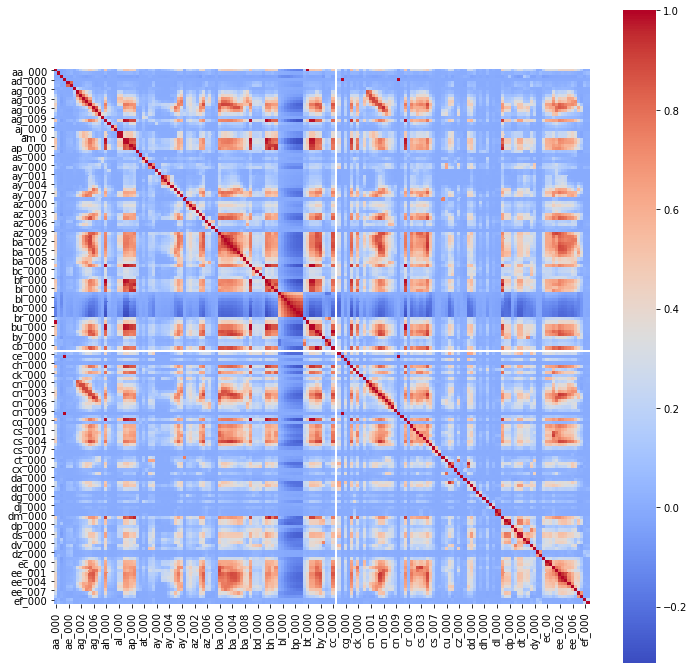

In [4]:
all_attrib_corr_matrix = all_attributes.corr()

display(all_attrib_corr_matrix)

plt.figure(figsize=(12, 12))
sns.heatmap(all_attrib_corr_matrix, annot=False, cmap="coolwarm", square=True)
plt.show()

iv. Pick sqrt(170) features with highest CV, and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

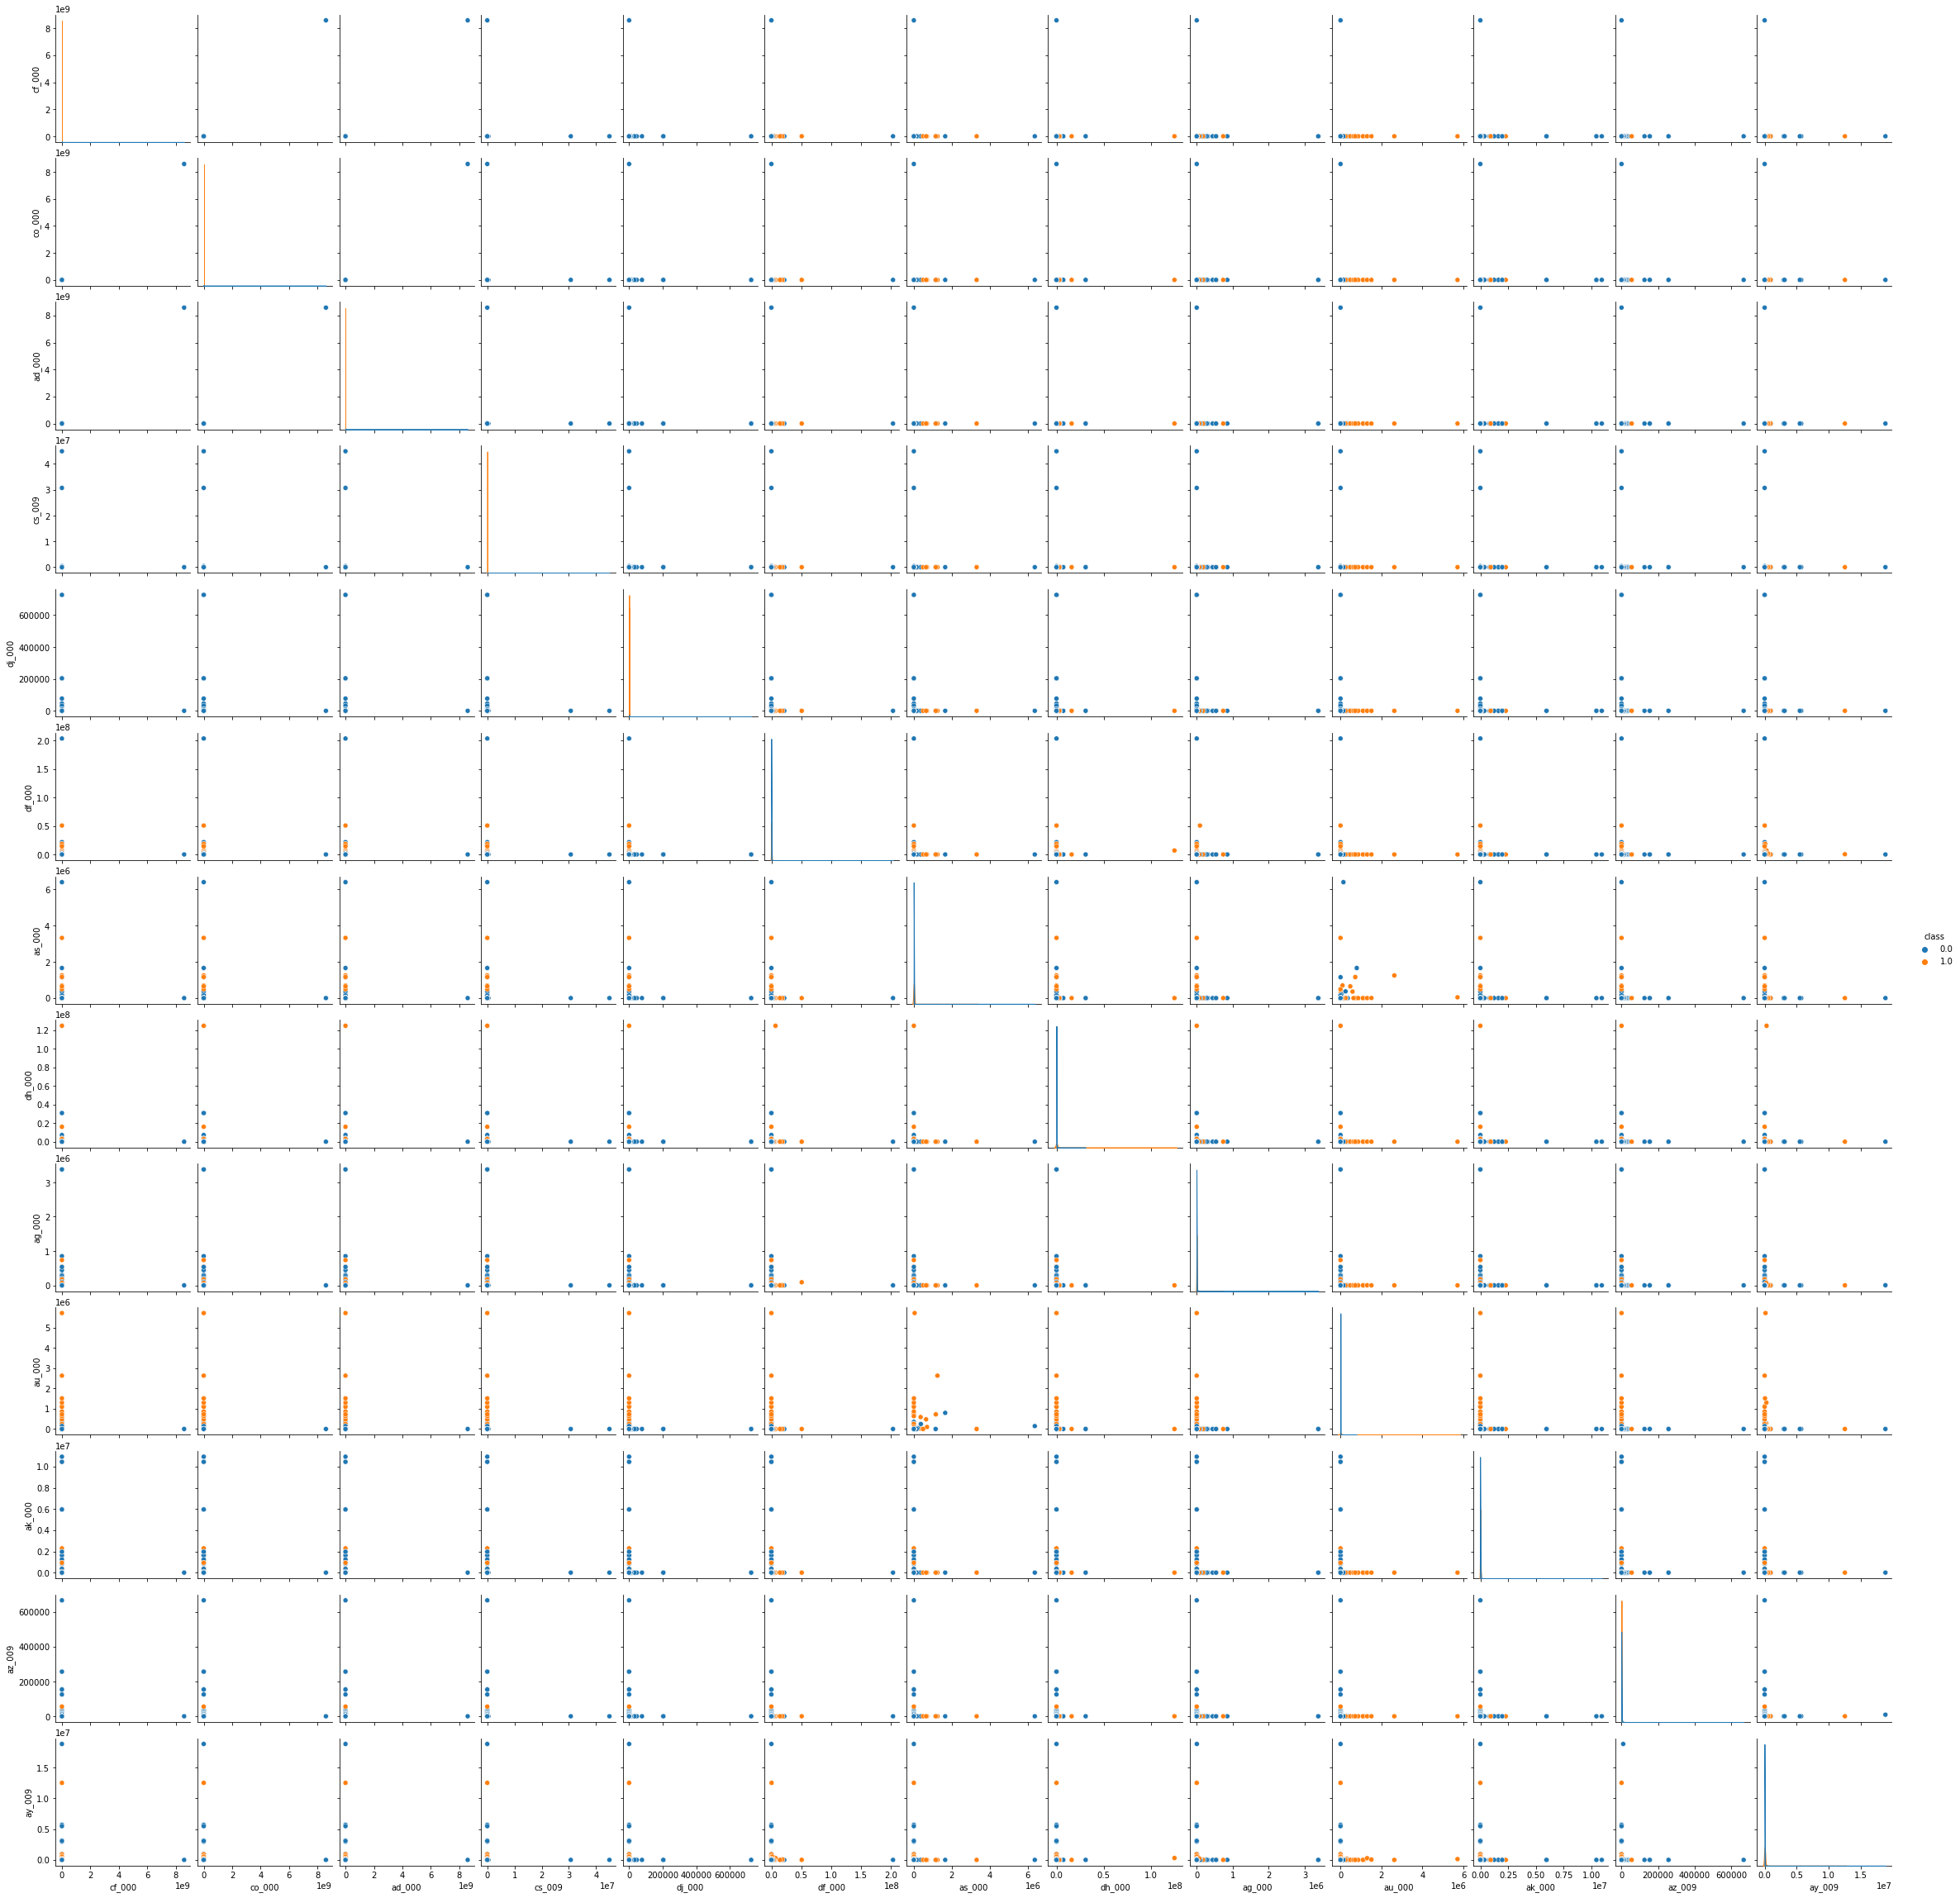

The scatterplots don't reveal all that much, since the data is pretty scattered, but we can see that some predictors have very clear separation between classes.


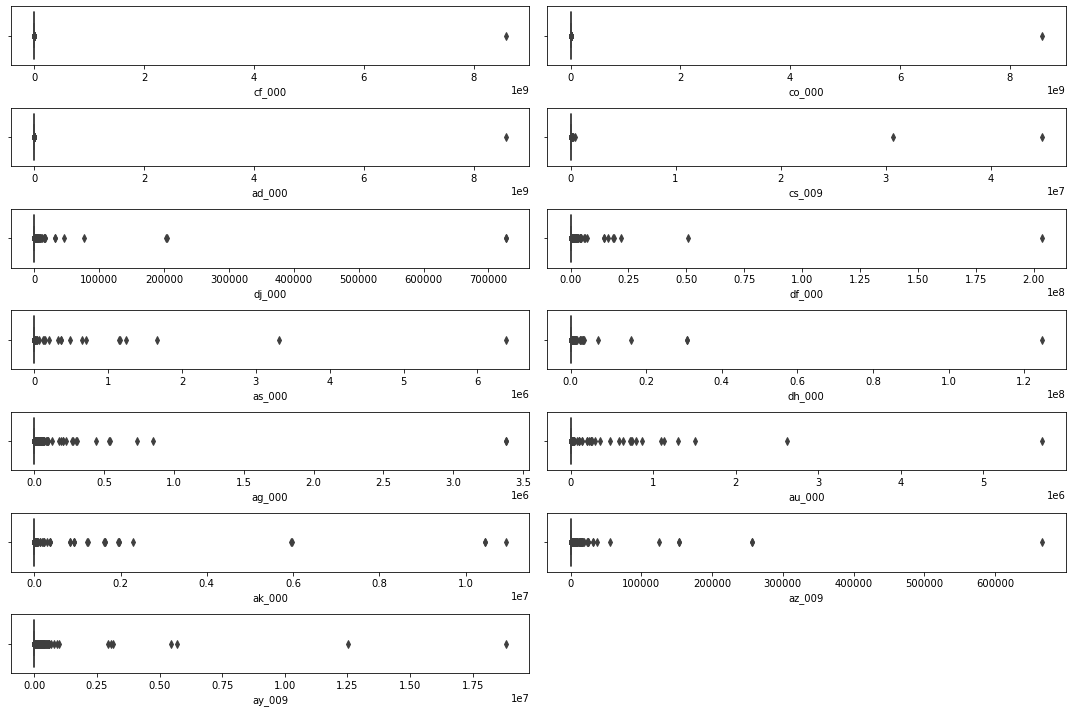

The boxplots also don't show much, but the most important thing to note is that each of the predictors have many outliers.


In [5]:
# sort coefficients of variation in descending order
coeff_df_sorted = coeff_df.sort_values(by='cv', ascending=False)
top_features = coeff_df_sorted.head(13) # sqrt(170) = 13.0384

selected_features = top_features['feature'].to_list()
selected_features.append('class')

# scatterplot
sns.pairplot(all_data[selected_features], hue='class')
plt.show()

print("The scatterplots don't reveal all that much, since the data is pretty scattered, but we can see that some predictors have very clear separation between classes.")

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 10))
axes = axes.flatten()

# boxplots
for i, feature in enumerate(top_features['feature']):
    sns.boxplot(x=all_attributes[feature], ax=axes[i])

axes[13].set_visible(False)

plt.tight_layout()
plt.show()

print("The boxplots also don't show much, but the most important thing to note is that each of the predictors have many outliers.")

v. Determine the number of positive and negative data. Is this data set imbalanced?

In [6]:
pos_count = all_labels[all_labels == 1].count()
neg_count = all_labels[all_labels == 0].count()
ratio = pos_count / (pos_count + neg_count)

print(f"\nThe dataset is heavily imbalanced because the positive to negative class ratio is {(100 * ratio):.4f}%.")


The dataset is heavily imbalanced because the positive to negative class ratio is 1.8092%.


(c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

METRICS FOR TRAINING DATA:
The confusion matrix is:
[[58976    24]
 [  432   568]]
The ROC curve has an AUC of: 0.7838
The misclassification rate is: 0.0076


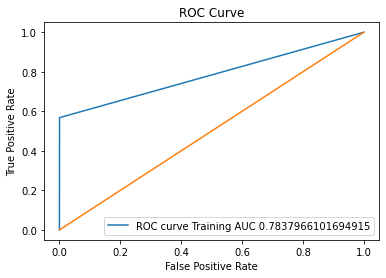

METRICS FOR TESTING DATA:
The confusion matrix is:
[[15611    14]
 [  173   202]]
The ROC curve has an AUC of: 0.7689
The misclassification rate is: 0.0117


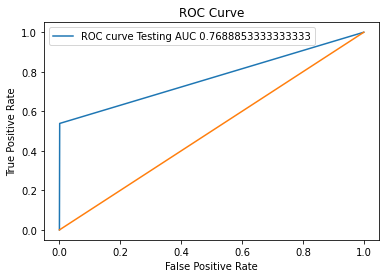

The out-of-bag error is: 0.0093
Since the out-of-bag error is less than the test error, that suggests that the model is potentially overfitting.


In [7]:
# REFERENCE: Site #2
random_forest = RandomForestClassifier(max_depth=5, random_state=42, oob_score=True)
random_forest.fit(X_train, Y_train)

# turned this into a function because i realized i'd be using it everywhere
def calculate_metrics(model):

    # !!! TRAINING DATA !!!
    print("METRICS FOR TRAINING DATA:")

    Y_pred = model.predict(X_train)

    # calculate confusion matrix
    Y_pred_classification = np.where(Y_pred > 0.5, 1, 0) # convert probabilities to binary values for confusion matrix
    conf_matrix = confusion_matrix(Y_train, Y_pred_classification)
    print("The confusion matrix is:")
    print(conf_matrix)

    # calculate ROC curve
    fpr, tpr, thresholds = roc_curve(Y_train, Y_pred)
    roc_auc = auc(fpr, tpr)
    print(f"The ROC curve has an AUC of: {roc_auc:.4f}")

    # calculate missclassification rate
    TN, FP, FN, TP = conf_matrix.ravel()
    misclassification_rate = (FP + FN) / (TP + TN + FP + FN)
    print(f'The misclassification rate is: {misclassification_rate:.4f}')

    # REFERENCE: Site #3
    plt.figure()  
    plt.plot(fpr, tpr, label=f'ROC curve Training AUC {roc_auc}')
    plt.plot([0, 1], [0, 1], '-')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    ########################################################################################################################

    # !!! TESTING DATA !!!
    print("METRICS FOR TESTING DATA:")

    # calculate confusion matrix
    Y_pred = model.predict(X_test)

    # calculate confusion matrix
    Y_pred_classification = np.where(Y_pred > 0.5, 1, 0) # convert probabilities to binary values for confusion matrix
    conf_matrix = confusion_matrix(Y_test, Y_pred_classification)
    print("The confusion matrix is:")
    print(conf_matrix)

    # calculate ROC curve
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
    roc_auc = auc(fpr, tpr)
    print(f"The ROC curve has an AUC of: {roc_auc:.4f}")

    # calculate missclassification rate
    TN, FP, FN, TP = conf_matrix.ravel()
    misclassification_rate = (FP + FN) / (TP + TN + FP + FN)
    print(f'The misclassification rate is: {misclassification_rate:.4f}')

    plt.figure()  
    plt.plot(fpr, tpr, label=f'ROC curve Testing AUC {roc_auc}')
    plt.plot([0, 1], [0, 1], '-')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

calculate_metrics(random_forest)

out_of_bag_error = 1 - random_forest.oob_score_
print(f"The out-of-bag error is: {out_of_bag_error:.4f}")
print("Since the out-of-bag error is less than the test error, that suggests that the model is potentially overfitting.")

comparison_results = []
comparison_results.append({"model": "Random Forest", "out of bag error": out_of_bag_error, "misclassification error": 0.0117, "difference": abs(out_of_bag_error - 0.0117)})

(d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 1c. Compare the results with those of 1c.  

Random Forest models can be adjusted to assign higher weights to the minority class samples during training. This can be done by setting the class_weight parameter (in sklearn) to "balanced."

METRICS FOR TRAINING DATA:
The confusion matrix is:
[[56610  2390]
 [   31   969]]
The ROC curve has an AUC of: 0.9642
The misclassification rate is: 0.0403


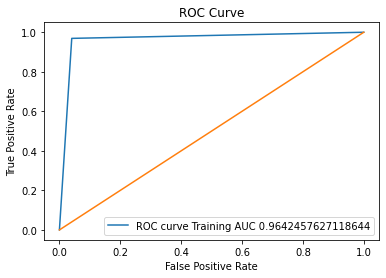

METRICS FOR TESTING DATA:
The confusion matrix is:
[[15013   612]
 [   12   363]]
The ROC curve has an AUC of: 0.9644
The misclassification rate is: 0.0390


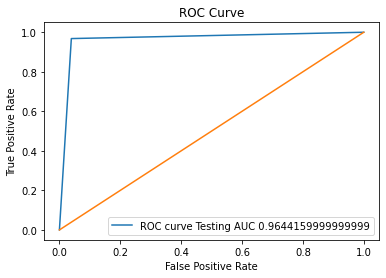

The out-of-bag error is: 0.0416


,model,out of bag error,misclassification error,difference
0,Random Forest,0.009283,0.0117,0.002417
1,Random Forest (Balanced),0.041567,0.0390,0.002567


We can clearly see that the balanced model has a higher misclassification and out-of-bag errors than the unbalanced model, meaning the model might be overfitting.
Additionally, the difference in the out-of-bag error and the misclassification error is larger for the balanced model.
However, the AUC and ROC cruve are better for the balanced case than the unbalanced one.


In [8]:
# REFERENCE: Site #4
random_forest_balanced = RandomForestClassifier(max_depth=5, random_state=42, class_weight='balanced', oob_score=True)
random_forest_balanced.fit(X_train, Y_train)

calculate_metrics(random_forest_balanced)

out_of_bag_error = 1 - random_forest_balanced.oob_score_
print(f"The out-of-bag error is: {out_of_bag_error:.4f}")

comparison_results.append({"model": "Random Forest (Balanced)", "out of bag error": out_of_bag_error, "misclassification error": 0.0390, "difference": abs(out_of_bag_error - 0.0390)})
comparison_results_df = pd.DataFrame(comparison_results)
display(comparison_results_df)
print("We can clearly see that the balanced model has a higher misclassification and out-of-bag errors than the unbalanced model, meaning the model might be overfitting.")
print("Additionally, the difference in the out-of-bag error and the misclassification error is larger for the balanced model.")
print("However, the AUC and ROC cruve are better for the balanced case than the unbalanced one.")


(e) XGBoost and Model Trees  
One of the methods that can be used at each node is Logistic Regression. Because the number of variables is large in this problem, one can use L1-penalized logistic regression at each node. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

Best alpha: 0.0001
METRICS FOR TRAINING DATA:
The confusion matrix is:
[[59000     0]
 [    1   999]]
The ROC curve has an AUC of: 1.0000
The misclassification rate is: 0.0000


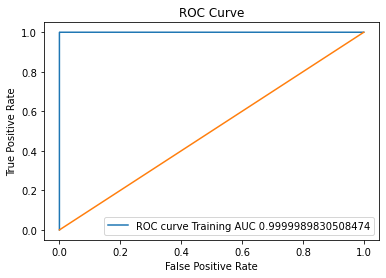

METRICS FOR TESTING DATA:
The confusion matrix is:
[[15607    18]
 [   81   294]]
The ROC curve has an AUC of: 0.9951
The misclassification rate is: 0.0062


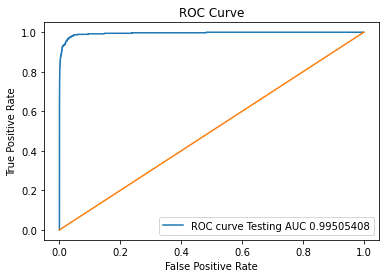

In [9]:
results = []

alphas = [0.0001, 0.001, 0.01, 0, 0.1, 1, 10]
param_grid = {'alpha': alphas}

xgb_model = xgb.XGBRegressor(objective="binary:logistic", random_state=42)

# REFERENCE: Site #5
# find best alpha for xgb
grid_search = GridSearchCV(estimator=xgb_model, cv=5, param_grid=param_grid, scoring='neg_log_loss')
grid_search.fit(X_train, Y_train)
best_alpha = grid_search.best_params_['alpha']

print(f'Best alpha: {best_alpha}')

# fit xgb model with new best alpha
xgb_model = xgb.XGBRegressor(objective="binary:logistic", random_state=42, alpha=best_alpha)
xgb_model.fit(X_train, Y_train)

calculate_metrics(xgb_model)

results.append({"model": "XGBoost (Non-SMOTE)", "misclassification error": 0.0062})

(f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance. Train XGBoost with L1-penalized logistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.

METRICS FOR TRAINING DATA:
The confusion matrix is:
[[59000     0]
 [    1   999]]
The ROC curve has an AUC of: 1.0000
The misclassification rate is: 0.0000


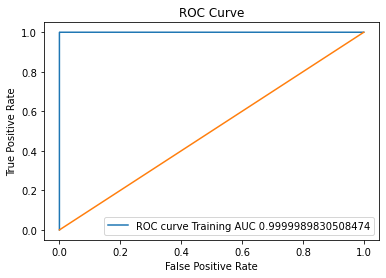

METRICS FOR TESTING DATA:
The confusion matrix is:
[[15607    18]
 [   81   294]]
The ROC curve has an AUC of: 0.9951
The misclassification rate is: 0.0062


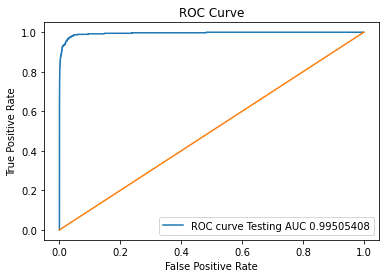

,model,misclassification error
0,XGBoost (Non-SMOTE),0.0062
1,XGBoost (SMOTE),0.0073


As we can see based off of the table, the misclassification rate is lower for the non-SMOTE model than the SMOTE model, meaning the SMOTE model performed worse.
Furthermore, the SMOTE ROC Curve has a lower AUC than the non-SMOTE model, further proving that the non-SMOTE model performed better.


In [10]:
# REFERENCE: Site #6
# correct way to use SMOTE: apply it only to the TRAINING set
smote = SMOTE(random_state=42)
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)

xgb = xgb.XGBRegressor(objective='binary:logistic', alpha=best_alpha, random_state=42)

# REFERENCE: Site #7
# cross-validate the folds
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_smote = cross_val_score(xgb, X_train_smote, Y_train_smote, cv=fold, scoring='roc_auc')

# testing time!
xgb.fit(X_train_smote, Y_train_smote)
Y_pred_smote = xgb.predict(X_test)

calculate_metrics(xgb_model)

results.append({"model": "XGBoost (SMOTE)", "misclassification error": 0.0073})
results_df = pd.DataFrame(results)
display(results_df)
print("As we can see based off of the table, the misclassification rate is lower for the non-SMOTE model than the SMOTE model, meaning the SMOTE model performed worse.")
print("Furthermore, the SMOTE ROC Curve has a lower AUC than the non-SMOTE model, further proving that the non-SMOTE model performed better.")

### Question 2
#### ISLR 6.6.3  
Suppose we estimate the regression coeﬀicients in a linear regression model by minimizing  
sum (i = 1 to n) (y_i − β_0 − sum (j = 1 to p) β_j*x_ij)^2, subject to sum (j = 1 to p) |β_j| ≤ s  
for a particular value of s. For parts (a) through (e), indicate which of i. through v. is correct. Justify your answer.  
(a) As we increase s from 0, the training RSS will:
1. Increase initially, and then eventually start decreasing in an
inverted U shape.
2. Decrease initially, and then eventually start increasing in a U shape.
3. Steadily increase.
4. Steadily decrease.
5. Remain constant.

iv - Steadily decrease. As s increases, the restriction on the betas becomes looser, allowing the model to better fit the training data by adjusting the coefficients. This will lead to a decrease in the training RSS, since the model is given more freedom to fit the data, minimizing residuals.

(b) Repeat (a) for test RSS.  

ii - Decrease initially, and then eventually start increasing in a U shape. As s increases from 0, the model gains more flexibility (like in (a)), and the test RSS will initially decrease as the model better captures patterns in the data. However, beyond a certain point, further increasing s allows the model to become too flexible, leading to overfitting to the training data. This overfitting results in an increase in the test RSS, forming a U-shaped curve.    

(c) Repeat (a) for variance.  

iii - Steadily increase. As s increases, the constraint on the coefficients is relaxed, allowing the coefficients to take on larger absolute values. This added flexibility results in greater variance in the estimated coefficients because they are more sensitive to the specific training data. Thus, the variance of the model will steadily increase as s increases.  

(d) Repeat (a) for (squared) bias.  

iv - Steadily decrease. With a very small s, the constraint forces the coefficients β_j to be small or zero, leading to a high bias as the model is overly simplified. As s increases, this constraint is relaxed, and the model can better capture the underlying patterns in the data, reducing the bias. Therefore, as s increases, the (squared) bias of the model steadily decreases.

(e) Repeat (a) for the irreducible error.  

v - Remain constant. The irreducible error is unaffected by changes in s because it is not influenced by the model’s ability to fit the data or by the values of the coefficients. It is an inherent and unpredictable part of the regression process. Therefore, as s changes, the irreducible error remains constant.

### Question 3
#### ISLR 6.6.5  
It is well-known that ridge regression tends to give similar coeﬀicient values to correlated variables, whereas the lasso may give quite different coeﬀicient values to correlated variables. We will now explore this property in a very simple setting.  
Suppose that n = 2, p = 2, x_11 = x_12, x_21 = x_22. Furthermore, suppose that y1 + y2 = 0 and x_11 + x_21 = 0 and x_12 + x_22 = 0, so that the estimate for the intercept in a least squares, ridge regression, or lasso model is zero: βˆ0 = 0.  
(a) Write out the ridge regression optimization problem in this setting.

![a.png](images/a.png)

(b) Argue that in this setting, the ridge coeﬀicient estimates satisfy βˆ1 = βˆ2.

![b.png](images/b.png)

(c) Write out the lasso optimization problem in this setting.  

![c.png](images/c.png)

(d) Argue that in this setting, the lasso coeﬀicients βˆ1 and βˆ2 are not unique—-in other words, there are many possible solutions to the optimization problem in (c). Describe these solutions.

![d.png](images/d.png)

### Question 4
#### ISLR 8.4.5   
Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of X, produce 10 estimates of P(Class is Red|X):  
0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, and 0.75.  
There are two common ways to combine these results together into a single class prediction. One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?  

1. Majority Vote: In the majority vote approach, we classify based on the most frequent class label predicted by the bootstrapped models. Since each model provides a probability estimate P(Class is Red∣X), we assume that if this probability is greater than 0.5, the model predicts "Red," and if it is less than or equal to 0.5, the model predicts "Green." That means there are 6 predictions of "Red" and 4 predictions of "Green." Therefore, since the majority votes "Red," the classification is "Red."
2. Average Probability: In the average probability approach, we average the 10 probability estimates and classify based on whether the average probability is greater than 0.5:  
(0.1 + 0.15 + 0.2 + 0.2 + 0.55 + 0.6 + 0.6 + 0.65 + 0.7 + 0.75) / 10 = 4.5 / 10 = 0.45  
Therefore, since 0.45 < 0.5 the classification is "Green."

### Question 5
#### ISLR 9.7.3  
Here we explore the maximal margin classifier on a toy data set.  
(a) We are given n = 7 observations in p = 2 dimensions. For each observation, there is an associated class label. Sketch the observations.

,x1,x2,y
0,3,4,red
1,2,2,red
2,4,4,red
3,1,4,red
4,2,1,blue
5,4,3,blue
6,4,1,blue


<AxesSubplot:xlabel='x1', ylabel='x2'>

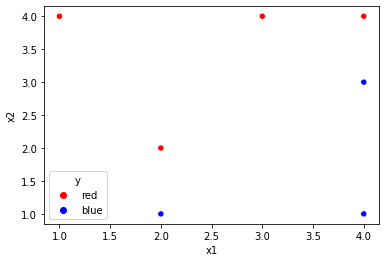

In [11]:
data = {"x1": [3, 2, 4, 1, 2, 4, 4], "x2": [4, 2, 4, 4, 1, 3, 1], "y": ["red", "red", "red", "red", "blue", "blue", "blue"]}
df = pd.DataFrame(data)
display(df)

# visualize the data
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette=['red', 'blue'])

(b) Sketch the optimal separating hyperplane, and provide the equation for this hyperplane (of the form (9.1)).  

The decision boundary should fall and separate the points (2, 2) (red) and (2, 1) (blue), as well as (4, 4) (red) and (4, 3) (blue). The midpoints between these 2 pairs of points are: ((2 + 2) / 2, (2 + 1) / 2) = (2, 1.5) and ((4 + 4) / 2, (4 + 3) / 2) = (4, 3.5). The slope between (2, 1.5) and (4, 3.5) is (3.5 - 1.5) / (4 - 2) = 2 / 2 = 1. Therefore, y = x + b. If we use the point (2, 1.5) --> 1.5 = 2 + b --> b = -0.5.

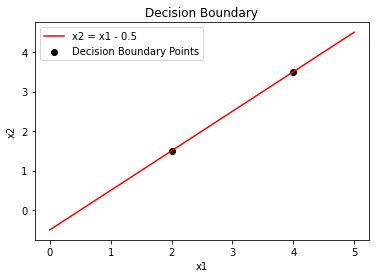

In [12]:
(x1, y1) = (2, 1.5)
(x2, y2) = (4, 3.5)
b = -0.5
m = (y2 - y1) / (x2 - x1)

x_values = np.linspace(0, 5, 20)
y_values = m * x_values + b

# plot decision boundary from points
plt.plot(x_values, y_values, '-', color="red", label="x2 = x1 - 0.5")
plt.scatter([x1, x2], [y1, y2], color="black", label='Decision Boundary Points')
plt.title("Decision Boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

(c) Describe the classification rule for the maximal margin classifier. It should be something along the lines of “Classify to Red if β0 + β1X1 + β2X2 > 0, and classify to Blue otherwise.” Provide the values for β0, β1, and β2.  

Since the decision boundary equation is x2 = x1 - 0.5, that can be rearranged to be -0.5 + x1 - x2 = 0. Therefore, the classification rule would be:  
"Classify to 'Red' if -0.5 + x1 - x2 > 0, and classify to 'Blue' otherwise."  
β0 = -0.5, β1 = 1, and β2 = -1

(d) On your sketch, indicate the margin for the maximal margin hyperplane.

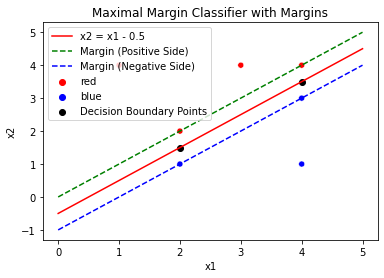

In [13]:
# original points
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette=['red', 'blue'])

# decision boundary and points
plt.plot(x_values, y_values, '-', color="red", label="x2 = x1 - 0.5")
plt.scatter([x1, x2], [y1, y2], color="black", label='Decision Boundary Points')

# margins
margin = 1
y_margin_pos = m * x_values
y_margin_neg = m * x_values - margin
plt.plot(x_values, y_margin_pos, '--', color="green", label="Margin (Positive Side)")
plt.plot(x_values, y_margin_neg, '--', color="blue", label="Margin (Negative Side)")

plt.title("Maximal Margin Classifier with Margins")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

(e) Indicate the support vectors for the maximal margin classifier.  

The support vectors are the black dots on the graph above.    

(f) Argue that a slight movement of the seventh observation would not affect the maximal margin hyperplane.  

Since the 7th observation, the point at (4, 1), is far from the hyperplane (and not within the margins), it is not considered when formulating the hyperplane. Therefore, it being moved, would not affect the hyperplane.

(g) Sketch a hyperplane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.  

A not optimal separating hyperplane can be seen on the below graph represented by the yellow line. The equation is:  
0.25 + x1 - x2 > 0

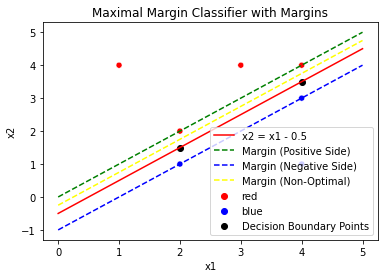

In [14]:
# original points
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette=['red', 'blue'])

# decision boundary and points
plt.plot(x_values, y_values, '-', color="red", label="x2 = x1 - 0.5")
plt.scatter([x1, x2], [y1, y2], color="black", label='Decision Boundary Points')

# margins
margin = 1
y_margin_pos = m * x_values
y_margin_neg = m * x_values - margin
y_margin_nonoptimal = m * x_values - 0.25
plt.plot(x_values, y_margin_pos, '--', color="green", label="Margin (Positive Side)")
plt.plot(x_values, y_margin_neg, '--', color="blue", label="Margin (Negative Side)")
plt.plot(x_values, y_margin_nonoptimal, '--', color="yellow", label="Margin (Non-Optimal)")

plt.title("Maximal Margin Classifier with Margins")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

(h) Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.

<AxesSubplot:xlabel='x1', ylabel='x2'>

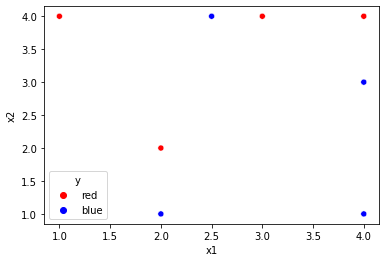

In [15]:
data = {"x1": [3, 2, 4, 1, 2, 4, 4, 2.5], "x2": [4, 2, 4, 4, 1, 3, 1, 4], "y": ["red", "red", "red", "red", "blue", "blue", "blue", "blue"]}
df = pd.DataFrame(data)

sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette=['red', 'blue'])

## References and Citations  
[#1 - StackOverflow on SimpleImputer](https://stackoverflow.com/questions/59439096/importerror-cannnot-import-name-imputer-from-sklearn-preprocessing)  
[#2 - RandomForestClassifier Documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  
[#3 - Plotting ROC Curve Tutorial](https://www.geeksforgeeks.org/how-to-plot-roc-curve-in-python/)  
[#4 - StackOverflow Balancing RandomForestClassifier](https://stackoverflow.com/questions/58275113/proper-use-of-class-weight-parameter-in-random-forest-classifier)  
[#5 - XGBoost and GridSearchCV Tutorial](https://www.kaggle.com/code/jayatou/xgbregressor-with-gridsearchcv)  
[#6 - SMOTE Documentation](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)  
[#7 - Using StratifiedKFold w/ cross_val_score](https://stackoverflow.com/questions/59002684/forcing-sklearn-cross-val-score-to-use-stratified-k-fold)  